# The Language of the Homeric Heroes

**A treebank-based approach**

[Francesco Mambrini](https://docenti.unicatt.it/ppd2/it/docenti/34146/francesco-mambrini/profilo) (Università Cattolica del Sacro Cuore)

This Notebook contains the code I used to analyze the data for Chapter 10 in the edited volume of the [DICES](https://www.dices.uni-rostock.de/en/about-dices/) network, entitled *Direct speech in Greek and Latin epic: expanding the methods and Canon*.

The chapter is entitled "The (annotated) language of the Homeric Heroes. Towards a treebank-based approach".

## Table of Content

1. [Introduction](#introduction)
    - [goals](#goal)
    - [data](#data)

2. [Results](#results)
    - [word distributions](#word-distributions)
    - [the generalizing overview](#the-generalizing-overview-with-delta)
    - [reading the patterns in the text](#reading-the-words-in-context)
    - [correlations](#correlations)

## Introduction

We start by loading some useful libraries for data analysis and visualization, such as [`pandas`](https://pandas.pydata.org/), [`scikit-learn`](https://scikit-learn.org/), [`scipy`](https://scipy.org/), [`matplotlib`](https://matplotlib.org/) and [`seaborn`](https://seaborn.pydata.org/index.html).

This Jupyter Notebook was tested on a kernel with Python 3.13.2. The list of requirements is available in the file `requirements.txt`.

In [2]:
from IPython.display import display, SVG, Image
import pandas as pd
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

The code in this notebook was also used to generate the figures for the paper. To comply with the Publisher's requests, I set the libraries to use the [Brill tts files](https://brill.com/page/510269?srsltid=AfmBOooXDkSL6ATS5tw_VBrYEwLG-wzmdNXX7TBwsBcU5t44bm9FtF8V).

If you want to replicate also this aspect, you may do so by following the following steps:
1. download and install the fonts from [this link](https://brill.com/page/510269?srsltid=AfmBOooXDkSL6ATS5tw_VBrYEwLG-wzmdNXX7TBwsBcU5t44bm9FtF8V).
2. run the next cell.

If you can't or don't want to install fonts on your system, you can safely skip the following cell and move to the other ones!

In [3]:
# Skip if you don't have the font installed

fs = 12
plt.rcParams.update({
    'font.family': 'Brill',
    'font.size': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'legend.fontsize': fs
})

In order to save some space for future runs, I have also defined some of the functions in a locally available file called `character_utils.py` that can be loaded as a Python module. This module provides also a faster way to load the dataframes files with all the calculations.

All the functions can be loaded simply by running:

```python
from chacater_utils import *
```

The current directory, however, **must** be in your python path!

Although it would be possible to use those functions directly from that "module", I will redefine most of them (though not all of them) in the current notebook. Hopefully, this will make the code more transparent and more readable, allowing readers to scrutinize what these functions do without opening another file. Some functions that are mostly used for visualization or to generate plots, however, will still be loaded from `character_utils`.

The [Ancient Greek and Latin Depenency Treebank](https://perseusdl.github.io/treebank_data/) contain the full text of the Iliad and Odyssey with word-by-word morphosyntactic annotation. Here is an example of the annotation that is stored in one of the files of the project.

```xml
<sentence subdoc="1.17-1.19" id="2274111" ...>
  <primary>millermo</primary>
  <primary>tovahk</primary>
  <secondary>nicanor</secondary>
  <word id="1" form="Ἀτρεΐδαι" lemma="Ἀτρείδης" postag="n-p---mv-" head="3" relation="ExD_CO" cite="urn:cts:greekLit:tlg0012.tlg001:1.17"/>
  <word id="2" form="τε" lemma="τε" postag="g--------" head="3" relation="AuxY"/>
  <word id="3" form="καὶ" lemma="καί" postag="c--------" head="11" relation="COORD" />
  <word id="4" form="ἄλλοι" lemma="ἄλλος" postag="a-p---mv-" head="6" relation="ATR"/>
  <word id="5" form="ἐϋκνήμιδες" lemma="ἐυκνήμις" postag="a-p---mv-" head="6"/>
  <word id="6" form="Ἀχαιοί" lemma="Ἀχαιός" postag="a-p---mv-" head="3"/>
  <word id="7" form="," lemma="," postag="u--------" head="3" relation="AuxX"/>
  <word id="8" form="ὑμῖν" lemma="σύ" postag="p-p----d-" head="11" relation="OBJ" >
    ...
  <word id="22" form="ἱκέσθαι" lemma="ἱκνέομαι" postag="v--anm---" head="20" relation="OBJ_CO" cite="urn:cts:greekLit:tlg0012.tlg001:1.19"/>
  <word id="23" form="·" lemma="·" postag="u--------" head="0" relation="AuxK" cite=""/>
</sentence>
```

Here is the same sentence (*Il.* 1.17-19) visualized as a dependency tree:

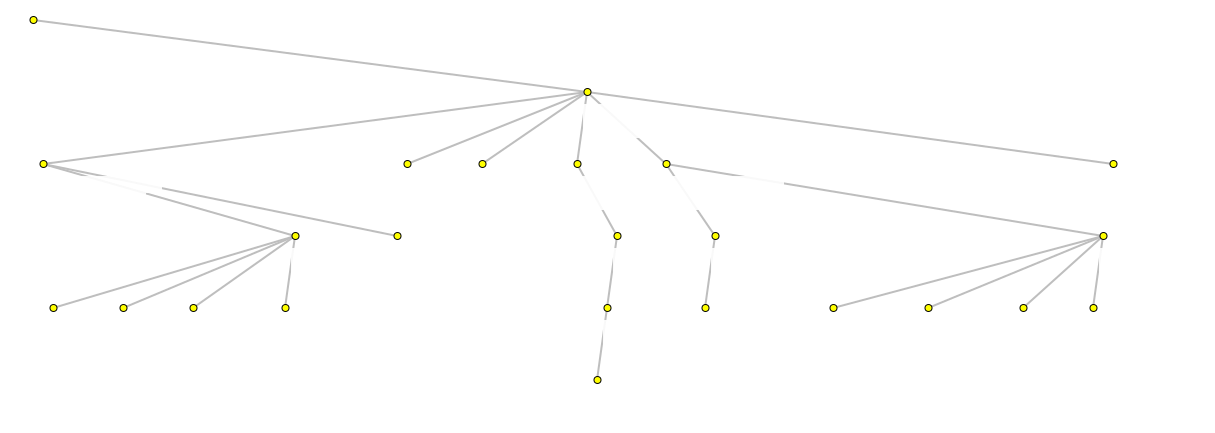

In [4]:
display(SVG('figures/treebank.svg'))

### Goal

My goals for the paper were to investigate the following questions:

1. how to make treebanks and DICES interact?
2. how we use treebanks to collect `comprehensive data` on the language of the characters in Greek literature?

(for a previous treebank-based work on the characterizaing in Sophocles see [this paper](https://classics-at.chs.harvard.edu/the-syntax-of-the-heroes-a-treebank-based-approach-to-the-language-of-the-sophoclean-characters/) on *Classics@*)

For this work on Homer, I will *not* make use of syntactic analysis, but instead I will rely on the two most basic layers of information in a treebank:
* lemma
* the morphology

```xml
<word form="ἐϋκνήμιδες" lemma="ἐυκνήμις" postag="a-p---mv-"/>
```

### Data

I have prepared a `pandas` DataFrame collecting:

- the complete vocabulary of the dialogue parts in *Iliad* and *Odyssey*
- the number of occurrence of every item in the vocabulary for each speaking character.

By "vocabulary" I don't mean word forms, as is more or less traditional in corpus-based exploration. The counts are in fact based on the lemmas recorded in the treebanks. Thus, "ἀνήρ", "ἀνέρες", "ἀνδρῶν" etc. are all lemmatized under "ἀνήρ". This is useful even for uninflected words like "δέ" as it elminates the hassle of having to deal with different forms and accentuations required in different contexts, like δέ, δὲ, δ' etc. All those forms are lemmatized under a unique form: δέ.

You should refer to the paper to read a full discussion on methodological problems such as: *what is a character?*, *what is a "speaking part"?* However, note the following points:

1. figures appearing in the 2 poems are 2 separated characters (so, we have 2 Odysseus': one for the *Iliad*, one for the *Odyssey*); in the dataframe, the character have a `_Il` or `_Od` tag to differentiate them.

2. I did *not* include the *apologoi* in *Od.* 9-11 as a direct speech attributed to Odysseus.

3. All the other speakers were attributed following the attribution in the DICES database.

4. I used DICES (and in particular the CTS URNs) to assign a speaker to a treebank sentence. In Homer, the correspondance of line, sentence and direct speech is straightforward (with only one possible exception that is not relevant in our study: see the paper).

The dataframe is saved in a [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) file included in this repository (`data/full_char_matrix_general.csv`). We load it in the next cell.

I have also collected all the treebanked sentences of direct speech (with speaker attribution) in two files in the `data` directory. My data come from the [Daphne](https://github.com/francescomambrini/Daphne/tree/master/data) "spin-off" of the AGLDT, which adopts the [Universal Dependencies](https://universaldependencies.org/) formalism. The files `data/dir_speech_il.conllu` and `data/dir_speech_od.conllu` are in the [CoNLL-U](https://universaldependencies.org/format.html) format. These files will be used [later](#correlations), when we explore the correlations of morphological features.

In [5]:
df = pd.read_csv('data/full_char_matrix_general.csv', index_col=0)
df.head()

,"""",;,̓ἀσκληπιάδης,̓ἀτρείδης,̓ἰασίων,̓ὀδυσσεύς,̓ὠγυγία,Αἰήτης,Αἰαίη,Αἰακίδης,...,ῥώομαι,ῥᾴδιος,ῥῆγος,ῥῆσις,ῥῖγος,Ῥέα,Ῥαδάμανθυς,Ῥεῖθρον,Ῥηξήνωρ,Ῥῆσος
Apollo_Il,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Athena_Il,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Helenos_Il,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hector_Il,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
bystander_Il,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


So, how many speakers are there in the two poems? And how big is the vocabulary in terms of treebank lemmas? Let's verify how many rows and columns our dataframe has to get an answer to these questions!

In [6]:
# We have a total of 170 speaking characters (in Il. e Od.)
# and about 6k lemmas

df.shape


(170, 5877)

If you want to know about *Iliad* and *Odyssey* separately, you can run the next cell (just change `'_Od'` into `'_Il'` to learn about the *Iliad*):

In [7]:
df[df.index.str.endswith('_Od')].shape 

# uncomment the line below to know about Il
# df[df.index.str.endswith('_Il')].shape 


(82, 5877)

#### Focus on the top 25 speakers

14 characters in *Il* and 11 in the *Od* speak more than 950 treebank tokens

In [8]:
char_freqs = df.sum(axis=1).sort_values(ascending=False)
top_char = char_freqs.head(25).index
char_freqs.head(25)

Odysseus_Od      12650
Achilles_Il       7128
Telemachus_Od     4951
Agamemnon_Il      3971
Nestor_Il         3790
Penelope_Od       3768
Hector_Il         3703
Athena_Od         3320
Eumaeus_Od        2990
Zeus_Il           2800
Odysseus_Il       2366
Menelaus_Od       2229
Hera_Il           1954
Diomedes_Il       1756
Nestor_Od         1667
Alcinous_Od       1588
Priamos_Il        1560
Antinous_Od       1480
Poseidon_Il       1323
Circe_Od          1321
Menelaos_Il       1216
Phoinix_Il        1193
Athena_Il         1109
Ajax_Il            980
Agamemnon_Od       966
dtype: int64

#### The top 40 words

We pick (as it is typical in authorship attribution) the most frequent words as a feature that we will be comparing in their distribution among the characters. But we keep the window pretty narrow: we focus of `grammatical words`. Content words that would make it easy to discriminate, but it will not be that insteresting...

After some experimenting (which is still visible, as the variable is still named `top_50`) I decided to set the threshold at 40 words. This number allows us to focus more on "gramatical" words, although still including some occasional lexical word.

In [9]:
word_freqs_gen = df.sum().sort_values(ascending=False)
top_50 = word_freqs_gen.head(60).index
top_50

Index(['δέ', 'καί', 'ἐγώ', 'τε', 'σύ', 'ὁ', 'εἰμί', 'ἄν', 'ὅς', 'οὐ', 'τις',
       'ἐν', 'ἀλλά', 'γάρ', 'μέν', 'γε', 'εἰ', 'οὐδέ', 'ἀνήρ', 'πᾶς', 'αὐτός',
       'δή', 'ὡς', 'ἤ', 'νῦν', 'ἐπί', 'ναῦς', 'ἄλλος', 'θεός', 'πολύς', 'εἰς',
       'φίλος', 'ὅδε', 'ἔρχομαι', 'Ἀχαιός', 'ἐπεί', 'Ζεύς', 'μή', 'πέρ',
       'θυμός', 'ἦ', 'ἕ', 'ἀτάρ', 'κακός', 'δίδωμι', 'μάλα', 'ἐκ', 'ἔχω',
       'Τρώς', 'οὗτος', 'ἐμός', 'κατά', 'μέγας', 'ἄρα', 'ἠδέ', 'πατήρ',
       'Ὀδυσσεύς', 'ὄφρα', 'μιν', 'εἶπον'],
      dtype='object')

Here we can leave out some words, mostly content words as said. Those words that we will leave out are commented out in the following cell

In [10]:
top_50 = ['δέ', 'καί', 'ἐγώ', 'τε', 'σύ', 'ὁ', 'εἰμί', 'ἄν', 'ὅς', 'οὐ', 'τις',
       'ἐν', 'ἀλλά', 'γάρ', 'μέν', 'γε', 'εἰ', 'οὐδέ', 'ἀνήρ', 'πᾶς', 'αὐτός',
       'δή', 'ὡς', 'ἤ', 'νῦν', 'ἐπί', #'ναῦς', 
       'ἄλλος', #'θεός', 
       'πολύς', 'εἰς',
       'φίλος', 'ὅδε', 'ἔρχομαι', #'Ἀχαιός', 
       'ἐπεί', #'Ζεύς', 
       'μή', 'πέρ',
       'θυμός', 'ἦ', 'ἕ', 'ἀτάρ', 'κακός', 'δίδωμι', 'μάλα', 'ἐκ', 'ἔχω',
       #'Τρώς', 
       'οὗτος', 'ἐμός', 'κατά', 'μέγας', 'ἄρα', 'ἠδέ'# 'πατήρ','Ὀδυσσεύς', 'ὄφρα', 'μιν', 'εἶπον'
       ]

top_50 = top_50[:40]
len(top_50)

40

The following code is used to generate the report in the Appendix A of the pubblication

In [11]:
st = ''

for w in top_50:
    tot_il = df[df.index.str.contains('_Il')][w].sum()
    tot_od = df[df.index.str.contains('_Od')][w].sum()
    st += f"{w} ({tot_il}, {tot_od}); "

print(st)

δέ (1864, 1674); καί (1531, 1524); ἐγώ (1307, 1307); τε (1012, 1105); σύ (963, 906); ὁ (928, 900); εἰμί (800, 809); ἄν (711, 589); ὅς (674, 616); οὐ (618, 664); τις (526, 674); ἐν (490, 601); ἀλλά (548, 519); γάρ (513, 499); μέν (492, 485); γε (336, 366); εἰ (398, 296); οὐδέ (362, 332); ἀνήρ (315, 330); πᾶς (311, 326); αὐτός (302, 329); δή (310, 320); ὡς (282, 321); ἤ (279, 300); νῦν (330, 245); ἐπί (274, 281); ἄλλος (262, 277); πολύς (255, 277); εἰς (181, 289); φίλος (229, 228); ὅδε (180, 274); ἔρχομαι (169, 279); ἐπεί (210, 215); μή (242, 176); πέρ (251, 165); θυμός (217, 187); ἦ (180, 204); ἕ (194, 174); ἀτάρ (151, 207); κακός (141, 217); 


In [12]:
len(top_50)

40

**Last bit**: we normalize the count of words (divide the nr. of occurrences per the total length of the spoken part of each character). To do that, we define a function that is also available in the `character_utils` package.

In [13]:
def create_normalized_per1000_matrix(df, nr_chr, custom_word_list):
    transformer = TfidfTransformer(norm='l1',
                               use_idf=False,
                               smooth_idf=False
                              )
    X = transformer.fit_transform(df) * 1000
    normdf = pd.DataFrame(X.toarray(), columns=df.columns, 
                         index=df.index)
    char_freqs = df.sum(axis=1).sort_values(ascending=False)
    top_char = char_freqs.head(nr_chr).index
    return normdf.loc[top_char, custom_word_list]

In [14]:
norm_df = create_normalized_per1000_matrix(df, 25, top_50)
norm_df.head()

,δέ,καί,ἐγώ,τε,σύ,ὁ,εἰμί,ἄν,ὅς,οὐ,...,ὅδε,ἔρχομαι,ἐπεί,μή,πέρ,θυμός,ἦ,ἕ,ἀτάρ,κακός
Odysseus_Od,34.940711,32.569170,37.865613,21.106719,16.205534,16.363636,15.652174,9.407115,9.723320,12.015810,...,5.296443,4.980237,4.031621,4.031621,3.162055,3.952569,3.794466,1.897233,4.584980,5.217391
Achilles_Il,34.511785,28.900112,30.864198,18.518519,18.097643,21.464646,12.345679,13.187430,14.029181,12.345679,...,3.367003,3.647587,5.611672,4.349046,5.190797,5.050505,4.910213,3.507295,3.367003,2.665544
Telemachus_Od,30.700869,29.892951,32.922642,21.207837,16.966269,16.360331,19.592002,15.350434,12.118764,15.754393,...,7.473238,4.847506,4.847506,4.847506,3.433650,4.241567,5.857403,3.029691,3.635629,4.645526
Agamemnon_Il,39.284815,30.219088,25.938051,19.138756,13.850416,15.361370,18.383279,14.857718,14.605893,12.339461,...,3.021909,3.777386,4.281038,5.036515,5.540166,3.525560,1.510954,2.770083,2.014606,2.770083
Nestor_Il,41.424802,28.759894,18.205805,19.525066,15.831135,21.899736,18.733509,14.248021,10.817942,10.290237,...,3.166227,3.166227,3.166227,2.902375,3.693931,3.166227,3.430079,2.902375,4.749340,0.791557


In [15]:
norm_df.shape

(25, 40)

### Methodology

Now we have a $25 \times 40$ **matrix**, with characters on the rows and frequent words in the columns.

Every speaking character is a 40x vector, a sort of point in 40-dimensional space. Can we measure how close or distant these vectors are?

I propose to use [Delta](10.1093/llc/17.3.267), a measure that is commonly used in stylometry to perform authorship attribution to establish how close/distant texts of disputed authorship are between each other.

In this way, we treat the speaking character as a sort of an author of their own speeches.

Delta is built on a statistical method to produce a standardized measure for the distribution of values around the mean called [z-scores](https://en.wikipedia.org/wiki/Standard_score). The next function will apply normalization based on z-scores on the dataframe.

In [16]:
def create_zsc_matrix(df, nr_chr, custom_word_list):
    transformer = TfidfTransformer(norm='l1',
                               use_idf=False,
                               smooth_idf=False
                              )
    X = transformer.fit_transform(df)
    normdf = pd.DataFrame(X.toarray(), columns=df.columns, 
                         index=df.index)
    char_freqs = df.sum(axis=1).sort_values(ascending=False)
    top_char = char_freqs.head(nr_chr).index
    zdf1k = pd.DataFrame(scale(normdf, with_mean=True), index=normdf.index, 
                     columns=normdf.columns)
    
    zdf = zdf1k.loc[top_char, custom_word_list]
    return zdf

In [17]:
zsc_df = create_zsc_matrix(df, 25, top_50)
zsc_df.head()

,δέ,καί,ἐγώ,τε,σύ,ὁ,εἰμί,ἄν,ὅς,οὐ,...,ὅδε,ἔρχομαι,ἐπεί,μή,πέρ,θυμός,ἦ,ἕ,ἀτάρ,κακός
Odysseus_Od,0.255429,0.250171,0.931514,0.164145,-0.194292,0.171814,-0.085086,-0.211496,-0.316721,-0.084094,...,-0.105073,0.006460,0.036213,-0.040876,-0.126869,0.109656,-0.110479,-0.332530,0.446370,0.286932
Achilles_Il,0.232052,0.043375,0.524742,0.013580,-0.119377,0.637588,-0.279246,0.129988,0.009279,-0.056831,...,-0.237358,-0.089854,0.276289,-0.002366,0.138430,0.280489,-0.000514,-0.113723,0.178571,-0.135059
Telemachus_Od,0.024347,0.099333,0.644335,0.170027,-0.164172,0.171512,0.146264,0.325377,-0.135360,0.224898,...,0.044171,-0.003132,0.160180,0.058107,-0.091353,0.154623,0.092838,-0.178630,0.237634,0.192364
Agamemnon_Il,0.492195,0.117715,0.238540,0.049661,-0.287540,0.080297,0.075287,0.280869,0.052942,-0.057345,...,-0.261018,-0.080473,0.074110,0.081037,0.184117,0.043215,-0.335537,-0.213910,-0.118784,-0.117772
Nestor_Il,0.608830,0.035472,-0.210692,0.072135,-0.209116,0.677316,0.095852,0.225794,-0.233846,-0.226712,...,-0.251123,-0.124643,-0.095276,-0.177875,-0.057315,-0.012695,-0.146393,-0.195932,0.482508,-0.444955


## Results

### Word distributions

We can rely on different visualization techniques to bring out interesting dynamics within our data!

We can plot:
* how words are distributed per character
* how characters are distributed per word


#### Compare characters

We load a function from `character_utils` to plot how different the distribution of z-scores around the mean is for couples of characters.

The first example is with Ajax (*Il*.) and Achilles (*Il*.), but you can go ahead and change the character index to plot other chacters! If you do, don't forget to add `_Il` or `_Od` after the character names.

If you want to see what characters are available for comparison, run the next cell and copy/paste any of the names!

In [18]:
zsc_df.index

Index(['Odysseus_Od', 'Achilles_Il', 'Telemachus_Od', 'Agamemnon_Il',
       'Nestor_Il', 'Penelope_Od', 'Hector_Il', 'Athena_Od', 'Eumaeus_Od',
       'Zeus_Il', 'Odysseus_Il', 'Menelaus_Od', 'Hera_Il', 'Diomedes_Il',
       'Nestor_Od', 'Alcinous_Od', 'Priamos_Il', 'Antinous_Od', 'Poseidon_Il',
       'Circe_Od', 'Menelaos_Il', 'Phoinix_Il', 'Athena_Il', 'Ajax_Il',
       'Agamemnon_Od'],
      dtype='object')

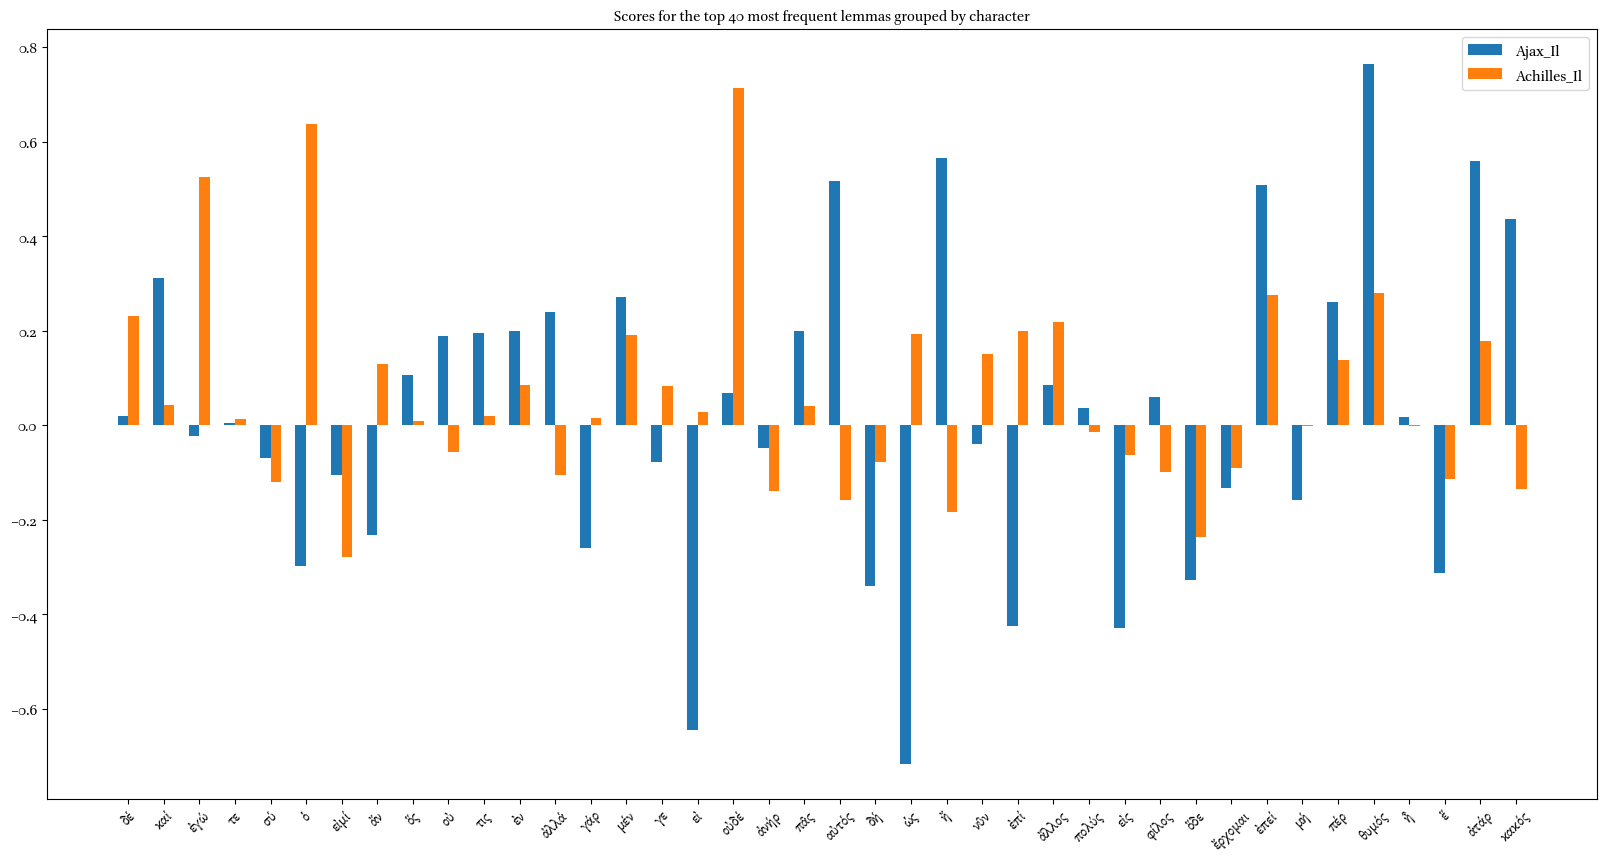

In [19]:
from character_utils import plot_chars

plot_chars(zsc_df, 'Ajax_Il', 'Achilles_Il', top_50, outfig='figures/figure2.png')

#### Compare words

Again, we load a function from `character_utils` to plot how the z-scores of couple of words vary around the mean for each of the 25 characters. The example is with νῦν and γάρ. Pick any of the top-40 words. If you want a list, see the next cell:

In [20]:
zsc_df.columns

Index(['δέ', 'καί', 'ἐγώ', 'τε', 'σύ', 'ὁ', 'εἰμί', 'ἄν', 'ὅς', 'οὐ', 'τις',
       'ἐν', 'ἀλλά', 'γάρ', 'μέν', 'γε', 'εἰ', 'οὐδέ', 'ἀνήρ', 'πᾶς', 'αὐτός',
       'δή', 'ὡς', 'ἤ', 'νῦν', 'ἐπί', 'ἄλλος', 'πολύς', 'εἰς', 'φίλος', 'ὅδε',
       'ἔρχομαι', 'ἐπεί', 'μή', 'πέρ', 'θυμός', 'ἦ', 'ἕ', 'ἀτάρ', 'κακός'],
      dtype='object')

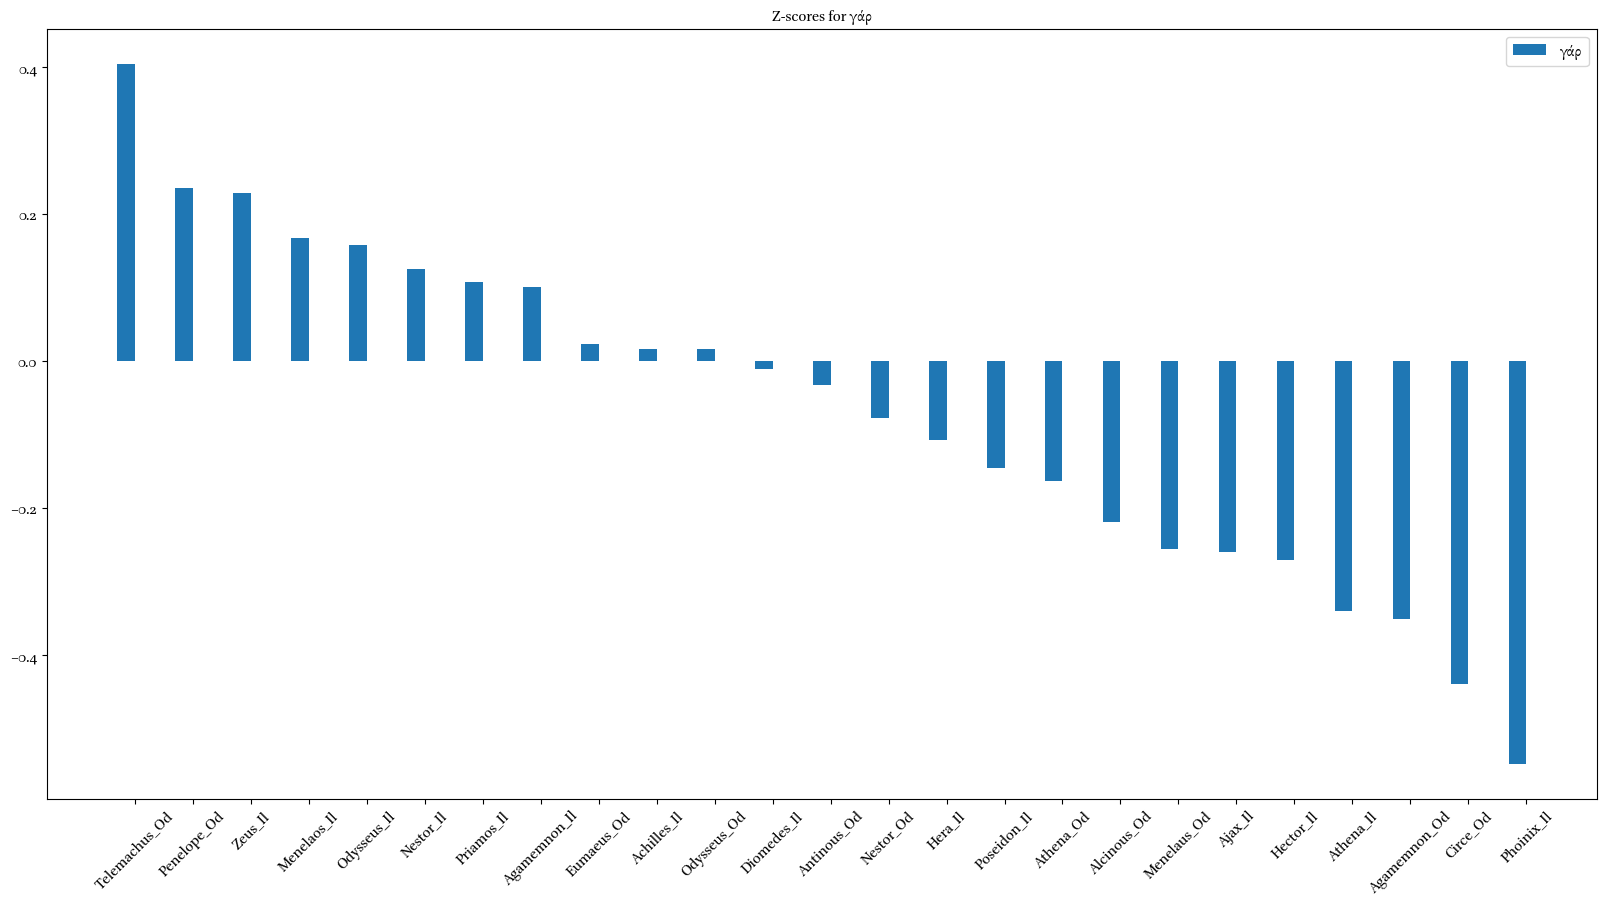

In [21]:
from character_utils import plot_words

# if you want one word only (e.g. γάρ), just repeat it twice!
plot_words(zsc_df.sort_values('γάρ', ascending=False), ['γάρ'])

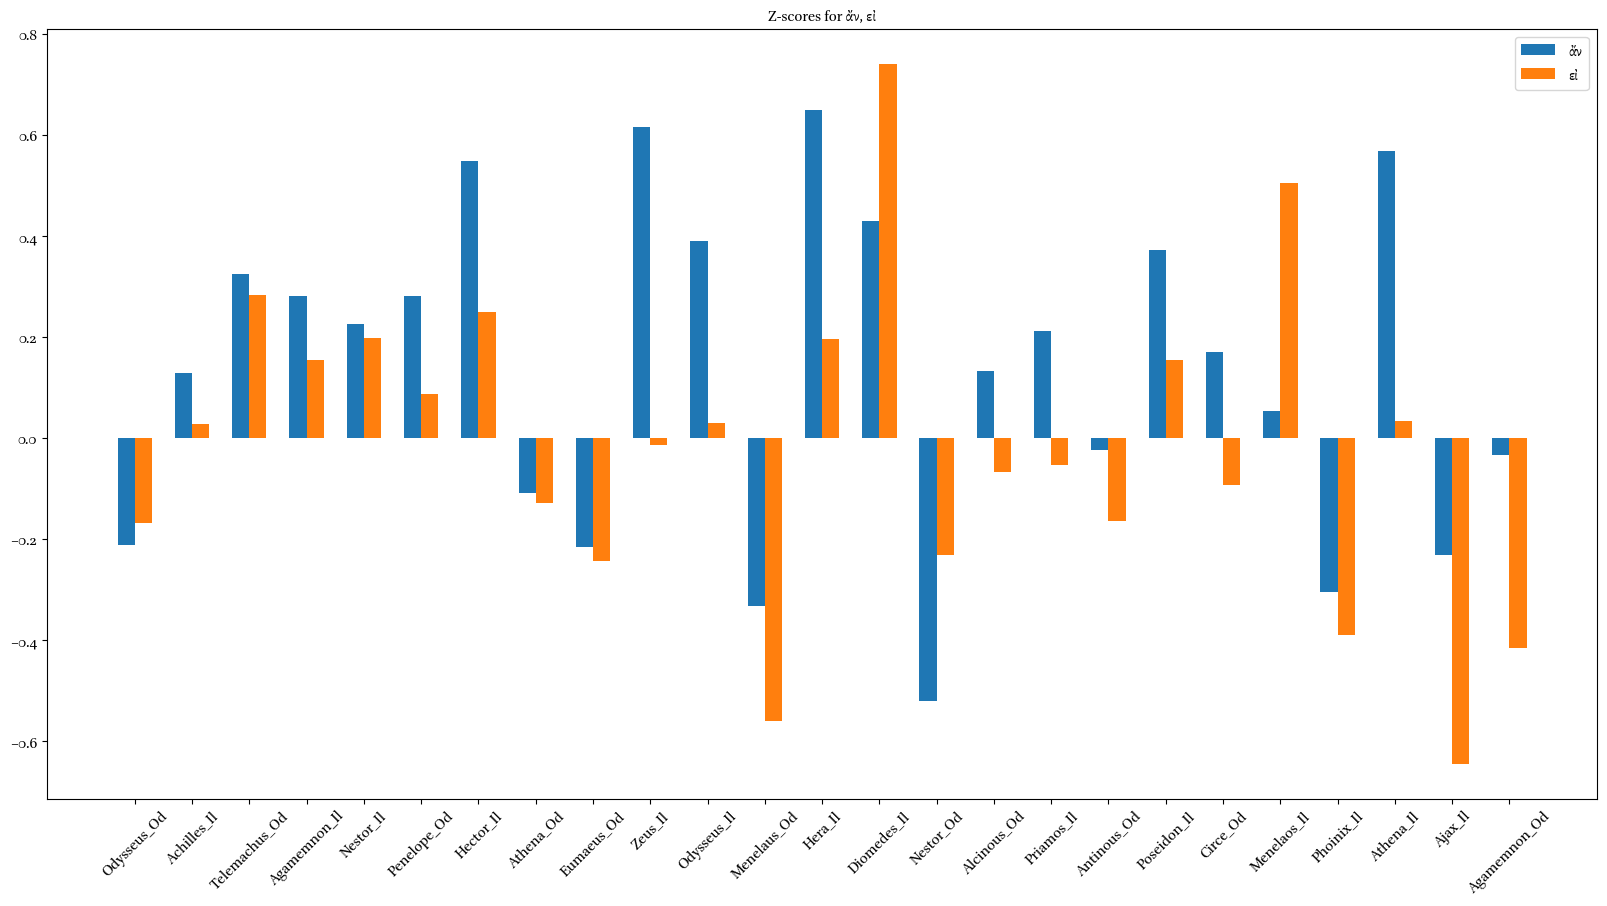

In [22]:
# Here we compare 2 words, ἄν and εἰ'!
# Try it with e.g. ἐπεί ἀλλά
plot_words(zsc_df, ['ἄν', 'εἰ'], width=0.1)

Would you like to have just a ordered list of the z-scores for a word? Use the code below!

In [23]:
zsc_df['γάρ'].sort_values(ascending=False)

Telemachus_Od    0.404882
Penelope_Od      0.235948
Zeus_Il          0.229575
Menelaos_Il      0.168032
Odysseus_Il      0.158113
Nestor_Il        0.125873
Priamos_Il       0.107855
Agamemnon_Il     0.101119
Eumaeus_Od       0.023414
Achilles_Il      0.016306
Odysseus_Od      0.016282
Diomedes_Il     -0.011023
Antinous_Od     -0.032684
Nestor_Od       -0.077764
Hera_Il         -0.106899
Poseidon_Il     -0.144591
Athena_Od       -0.162370
Alcinous_Od     -0.218650
Menelaus_Od     -0.255649
Ajax_Il         -0.259094
Hector_Il       -0.270971
Athena_Il       -0.340298
Agamemnon_Od    -0.350151
Circe_Od        -0.439300
Phoinix_Il      -0.547579
Name: γάρ, dtype: float64

### The generalizing overview with Delta

There are many different ways to visualize the distances between characters, calculated with Delta. We start by one, combining a `heatmap` with a `dendogram` of agglomerative clustering.

In order to calculate Delta we need to:
* express the frequencies in a standardize measure called `z-scores`
* calculate the distances between the vectors of z-scores

In [24]:
# the distance_matrix function to calculate the delta matrix is also available in character_utils.py
# the code is reported below to show how it works

def distance_matrix(zdf):
    distances = pdist(zdf.values, metric="cityblock") / len(zdf.columns)
    sqdistmat = squareform(distances)
    distdf = pd.DataFrame(sqdistmat, index=zdf.index, columns=zdf.index)
    return distdf

In [25]:
zsc = create_zsc_matrix(df, 25, top_50)
distances = pdist(zsc.values, metric="cityblock") / len(zsc.columns)
distdf = distance_matrix(zsc)
linkage_matrix = linkage(distances, "complete")

We now use the [`clustermap`](https://seaborn.pydata.org/generated/seaborn.clustermap.html) function of `seaborn` to generate the heatmap with the agglomerative clustering.

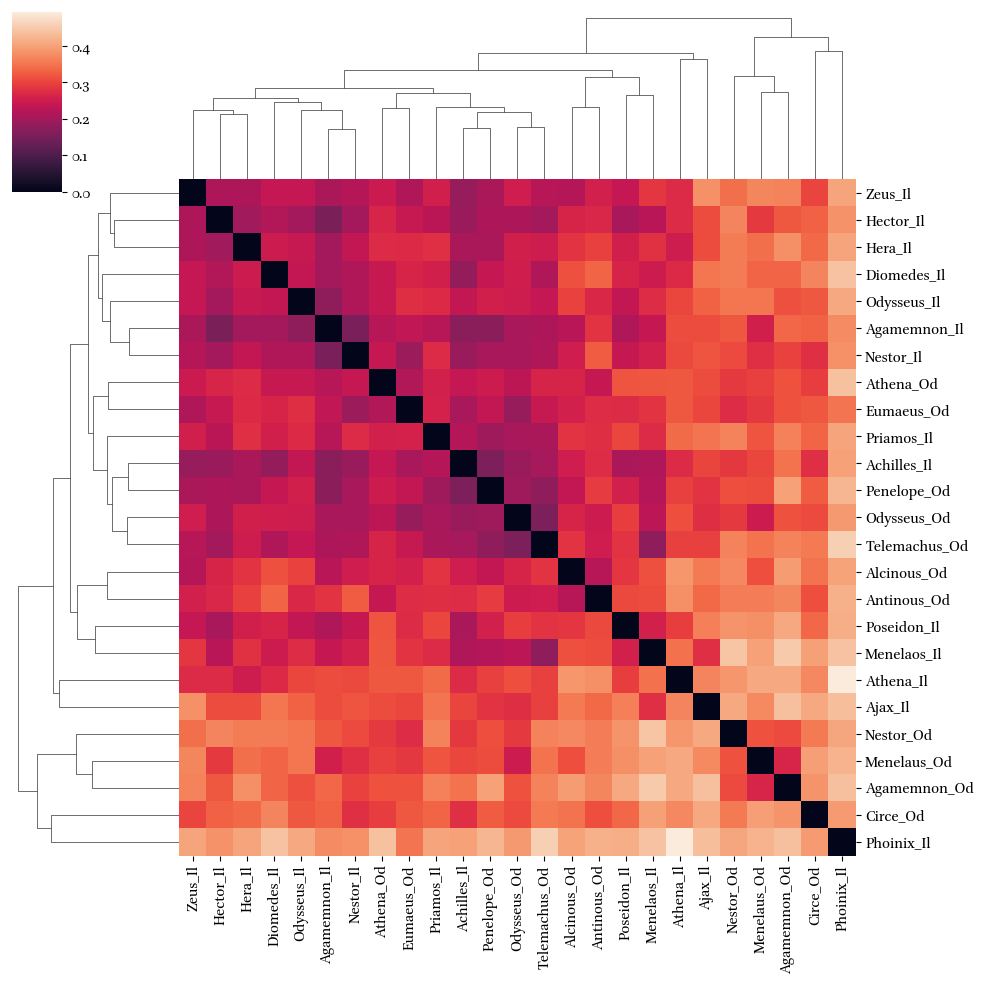

In [26]:
g = sns.clustermap(distdf,row_linkage=linkage_matrix, col_linkage=linkage_matrix)
g.savefig("figures/figure5.eps", format='eps', dpi=300)
plt.show()

#### The clusters

We can inspect the dendogram closer

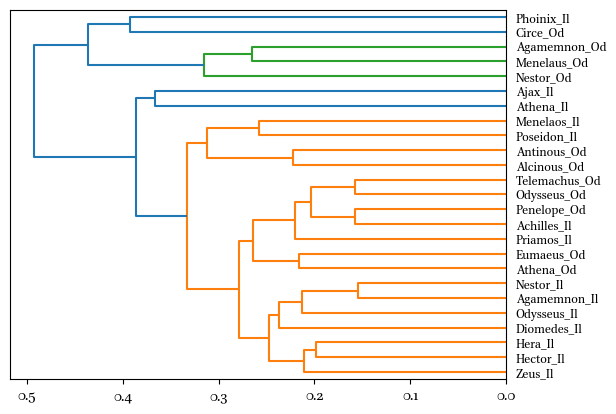

In [27]:
linkage_matrix = linkage(distances, "complete")
dendrogram(linkage_matrix, labels=zsc.index, orientation='left')
# plt.rcParams["figure.figsize"] = [12, 10]
plt.show()

But what happens if we change the linkage function?

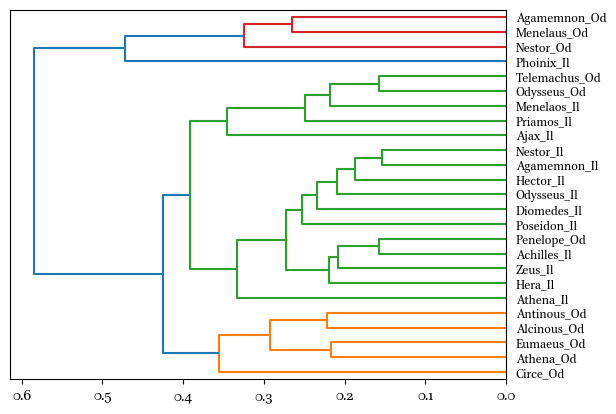

In [28]:
linkage_matrix = linkage(distances, "ward")
dendrogram(linkage_matrix, labels=zsc.index, orientation='left')
plt.show()

#### Principal Component Analysis

Another method to visualize the distances between characters. This time, let's focus on the *Iliad* (we use a shortcut in `character_utils` to create the dataframe with the Iliad characters).

In [29]:
from character_utils import df_il, do_pca

# do_pca is also available in character_utils.py
# the code is reported below to show how it works
def do_pca(df):
    pca = PCA(n_components=2)
    pca_corr_mat = pca.fit_transform(df)
    pca_res = pd.DataFrame(data = pca_corr_mat, columns = ['vector 1', 'vector 2'])#, 'vector 3'])#, 'vector 4'])
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_))
    return pca_res

zdf_il = create_zsc_matrix(df_il, 15, top_50)
distdf_il = distance_matrix(zdf_il)
pca_res_delta = do_pca(distdf_il)

[0.39982471 0.13270714]
0.5325318475835903


<Figure size 640x480 with 0 Axes>

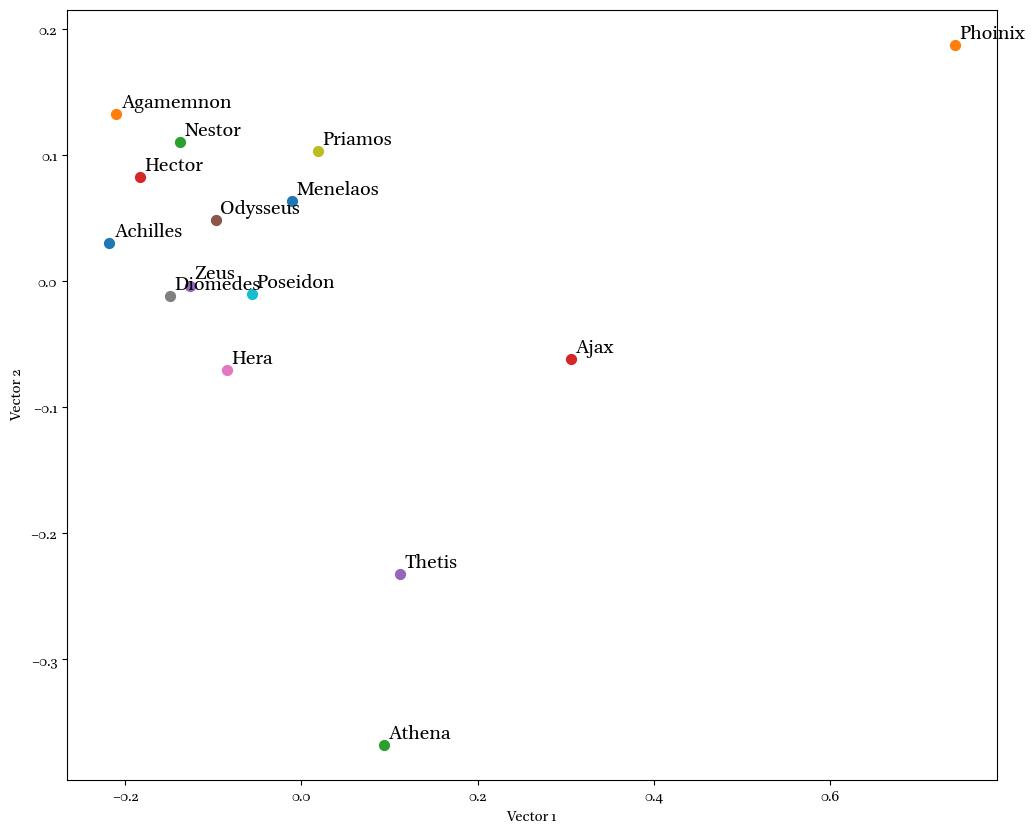

In [30]:
# we load the code to plot the PCA from character_utils.py
from character_utils import plot_pca

plot_pca(pca_res_delta, distdf_il)

[0.40753038 0.1115437 ]
0.519074074765089


<Figure size 640x480 with 0 Axes>

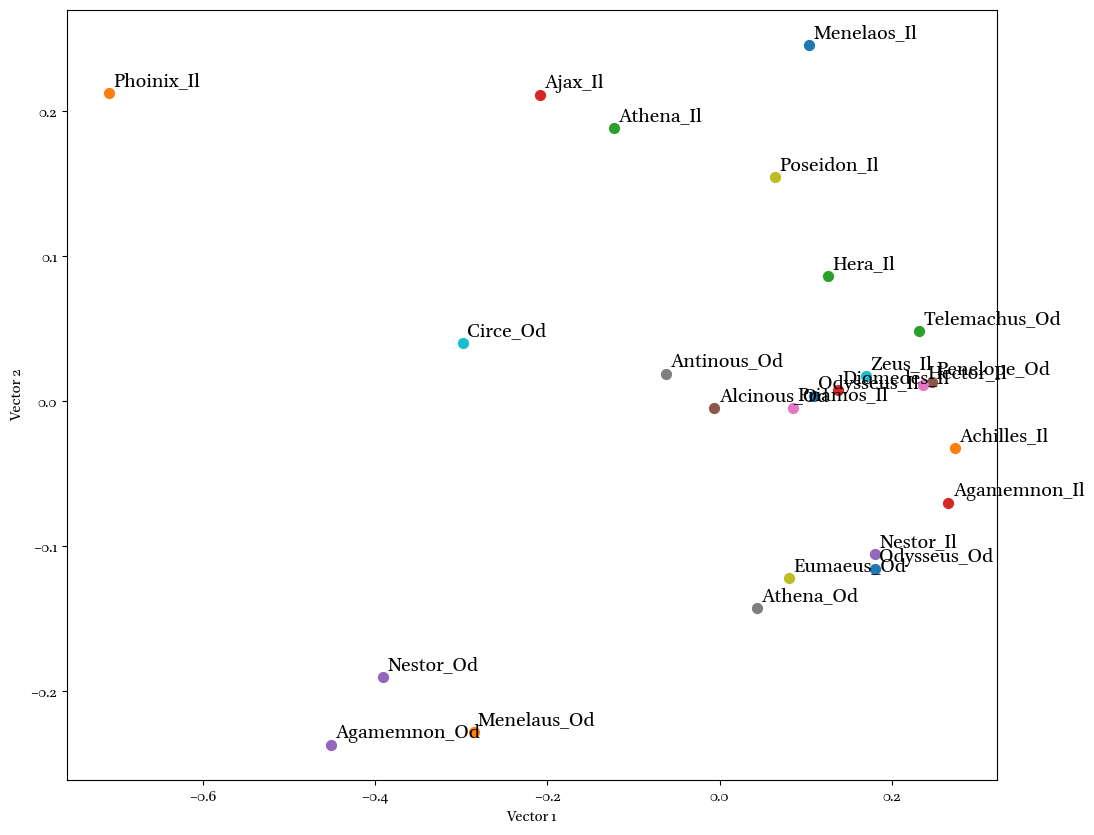

In [31]:
zdf = create_zsc_matrix(df, 25, top_50)
distdf = distance_matrix(zdf)
pca_res_delta = do_pca(distdf)

plot_pca(pca_res_delta, distdf)

In [32]:
def plot_group_pca(pca_res_df, char_df, outfig=None, dpi=300, format="png"):
    plt.figure()
    plt.figure(figsize=(12,10))
    plt.axes(xlabel='Vector 1', ylabel='Vector 2')
    for i in pca_res_df.index:
        word = char_df.iloc[i].name
        col = 'steelblue' if word.endswith('_Od') else 'salmon'
        x, y = pca_res_df.loc[i]["vector 1"] * -1, pca_res_df.loc[i]["vector 2"]
        plt.scatter(x, y, s=50, c=col,)
        plt.text(x+.005, y+.005, word[:3], fontsize=16)

    if outfig:
        plt.savefig(outfig, dpi=dpi, facecolor='white')
    plt.show()

<Figure size 640x480 with 0 Axes>

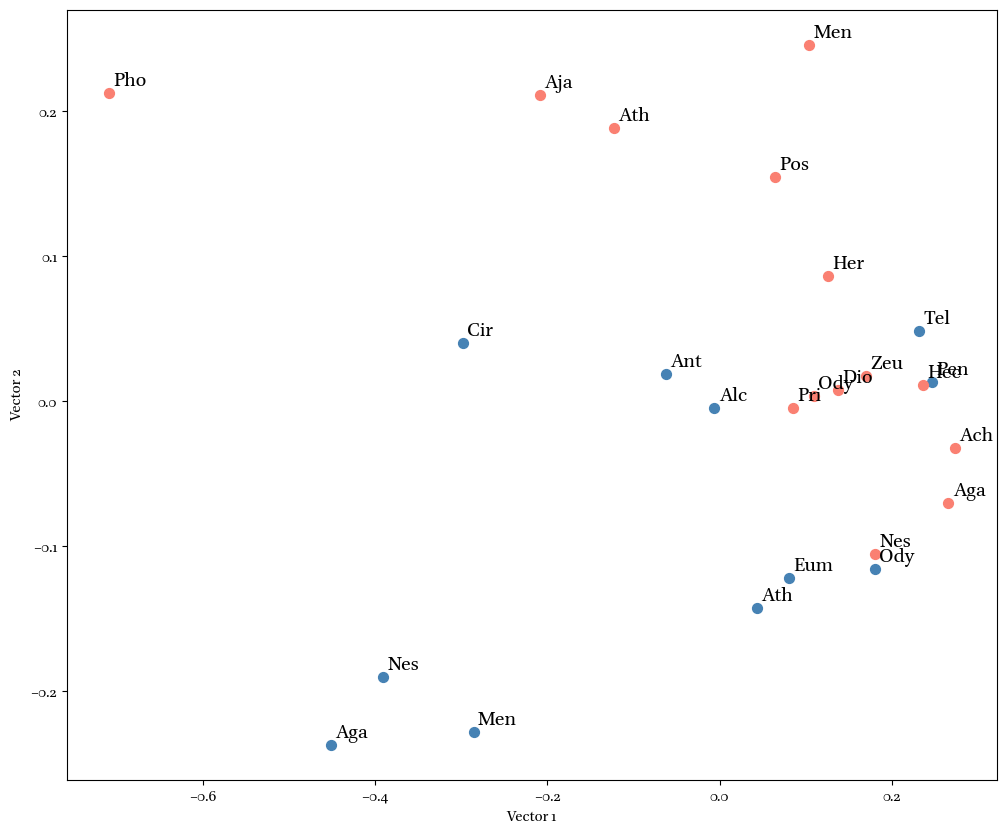

In [33]:
plot_group_pca(pca_res_delta, distdf, outfig='figures/figure4.eps', format='eps')

### Reading the words in context

As Gregory Crane said during the DICES conference in Mount Alison, what is important is not just that we use cool visualization tool to give bird-eye views on the trends in the data, but also that we make those trends visible *in the texts*!

We can retrieve and list all occurrences of interesting words, so as to actually see how they are used in context.

We use a couple of functions defined in `character_utils` to print concordance-like lines of text.

In [34]:
from character_utils import load_sents, create_speech_dic, print_occurrence

il_spk_sents = create_speech_dic(load_sents('./data/dir_speech_il.conllu'))
print_occurrence(il_spk_sents['Hector'], 'ἀλλά', 'white')

3.45 ἦ που καγχαλόωσι κάρη κομόωντες Ἀχαιοὶ φάντες ἀριστῆα πρόμον ἔμμεναι , οὕνεκα καλὸν εἶδος ἔπ' , ἀλλ' οὐκ ἔστι βίη φρεσὶν οὐδέ τις ἀλκή .
3.56 ἀλλὰ μάλα Τρῶες δειδήμονες ·
6.269 ἀλλὰ σὺ μὲν πρὸς νηὸν Ἀθηναίης ἀγελείης ἔρχεο σὺν θυέεσσιν ἀολλίσσασα γεραιάς ·
6.279 ἀλλὰ σὺ μὲν πρὸς νηὸν Ἀθηναίης ἀγελείης ἔρχευ , ἐγὼ δὲ Πάριν μετελεύσομαι ὄφρα καλέσσω αἴ κ' ἐθέλῃσ' εἰπόντος ἀκουέμεν ·
6.331 ἀλλ' ἄνα μὴ τάχα ἄστυ πυρὸς δηΐοιο θέρηται .
6.363 ἀλλὰ σύ γ' ὄρνυθι τοῦτον , ἐπειγέσθω δὲ καὶ αὐτός , ὥς κεν ἔμ' ἔντοσθεν πόλιος καταμάρψῃ ἐόντα .
6.441 ἀλλὰ μάλ' αἰνῶς αἰδέομαι Τρῶας καὶ Τρῳάδας ἑλκεσιπέπλους , αἴ κε E11.1 κακὸς ὣς νόσφιν ἀλυσκάζω πολέμοιο ·
6.450 ἀλλ' οὔ μοι Τρώων τόσσον μέλει ἄλγος ὀπίσσω , οὔ τ' αὐτῆς Ἑκάβης οὔ τε Πριάμοιο ἄνακτος οὔ τε κασιγνήτων , οἵ κεν πολέες τε καὶ ἐσθλοὶ ἐν κονίῃσι πέσοιεν ὑπ' ἀνδράσι δυσμενέεσσιν , E34.1 ὅσσον E35.1 σεῦ , ὅτε κέν τις Ἀχαιῶν χαλκοχιτώνων δακρυόεσσαν ἄγηται ἐλεύθερον ἦμαρ ἀπούρας ·
6.464 ἀλλά με τεθνηῶτα χυτὴ κατὰ γαῖα καλύπτοι πρίν γέ τι

In [35]:
il_spk_sents = create_speech_dic(load_sents('./data/dir_speech_od.conllu'))
print_occurrence(il_spk_sents['Telemachus'], 'γάρ', 'white')

1.173 οὐ μὲν γὰρ τί σε πεζὸν ὀίομαι ἐνθάδ' ἱκέσθαι .
1.216 οὐ γάρ πώ τις ἑὸν γόνον αὐτὸς ἀνέγνω .
1.245 ὅσσοι γὰρ νήσοισιν ἐπικρατέουσιν ἄριστοι , Δουλιχίῳ τε Σάμῃ τε καὶ ὑλήεντι Ζακύνθῳ , ἠδ' ὅσσοι κραναὴν Ἰθάκην κάτα κοιρανέουσιν , τόσσοι μητέρ' ἐμὴν μνῶνται , τρύχουσι δὲ οἶκον .
1.351 τὴν γὰρ ἀοιδὴν μᾶλλον ἐπικλείουσ' ἄνθρωποι , ἥ τις ἀκουόντεσσι νεωτάτη ἀμφιπέληται .
1.354 οὐ γὰρ Ὀδυσσεὺς οἶος ἀπώλεσε νόστιμον ἦμαρ ἐν Τροίῃ , πολλοὶ δὲ καὶ ἄλλοι φῶτες ὄλοντο .
1.359 τοῦ γὰρ κράτος ἔστ' ἐνὶ οἴκῳ . "
1.392 οὐ μὲν γάρ τι κακὸν βασιλευέμεν ·
2.58 E0.1 οὐ γὰρ ἔπ' ἀνήρ , οἷος Ὀδυσσεὺς ἔσκεν , ἀρὴν ἀπὸ οἴκου ἀμῦναι .
2.63 οὐ γὰρ ἔτ' ἀνσχετὰ ἔργα τετεύχαται , οὐδ' ἔτι καλῶς οἶκος ἐμὸς διόλωλε .
2.77 τόφρα γὰρ ἂν κατὰ ἄστυ ποτιπτυσσοίμεθα μύθῳ χρήματ' ἀπαιτίζοντες , ἕως κ' ἀπὸ πάντα δοθείη ·
2.134 ἐκ γὰρ τοῦ πατρὸς κακὰ πείσομαι , ἄλλα δὲ δαίμων δώσει , ἐπεὶ μήτηρ στυγερὰς ἀρήσετ' ἐρινῦς οἴκου ἀπερχομένη ·
2.211 ἤδη γὰρ τὰ ἴσασι θεοὶ καὶ πάντες Ἀχαιοί .
2.214 εἶμι γὰρ ἐς Σπάρτην τε καὶ ἐς Π

In [36]:
il_spk_sents = create_speech_dic(load_sents('./data/dir_speech_od.conllu'))
print_occurrence(il_spk_sents['Athena'], 'γάρ', 'white')

1.194 δὴ γάρ μιν ἔφαντ' ἐπιδήμιον εἶναι , σὸν πατέρ' ·
1.196 οὐ γάρ πω τέθνηκεν ἐπὶ χθονὶ δῖος Ὀδυσσεύς , ἀλλ' E10.1 ἔτι που ζωὸς κατερύκεται εὐρέι πόντῳ νήσῳ ἐν ἀμφιρύτῃ , χαλεποὶ δέ μιν ἄνδρες ἔχουσιν ἄγριοι , οἵ που κεῖνον ἐρυκανόωσ' ἀέκοντα .
1.255 εἰ γὰρ νῦν ἐλθὼν δόμου ἐν πρώτῃσι θύρῃσι σταίη , ἔχων πήληκα καὶ ἀσπίδα καὶ δύο δοῦρε , τοῖος ἐὼν οἷόν μιν ἐγὼ τὰ πρῶτ' ἐνόησα οἴκῳ ἐν ἡμετέρῳ πίνοντά τε τερπόμενόν τε , ἐξ Ἐφύρης ἀνιόντα παρ' Ἴλου Μερμερίδαο - ᾤχετο γὰρ καὶ κεῖσε θοῆς ἐπὶ νηὸς Ὀδυσσεὺς φάρμακον ἀνδροφόνον διζήμενος , ὄφρα οἱ εἴη ἰοὺς χρίεσθαι χαλκήρεας ·
1.265 φιλέεσκε γὰρ αἰνῶς - τοῖος ἐὼν μνηστῆρσιν ὁμιλήσειεν Ὀδυσσεύς ·
1.286 ὃς γὰρ δεύτατος ἦλθεν Ἀχαιῶν χαλκοχιτώνων .
1.301 καὶ σύ , φίλος , μάλα γάρ σ' ὁρόω καλόν τε μέγαν τε , ἄλκιμος ἔσσ' , ἵνα τίς σε καὶ ὀψιγόνων ἐὺ εἴπῃ .
2.276 παῦροι γάρ τοι παῖδες ὁμοῖοι πατρὶ πέλονται , οἱ πλέονες κακίους , παῦροι δέ τε πατρὸς ἀρείους .
2.286 τοῖος γάρ τοι ἑταῖρος ἐγὼ πατρώιός εἰμι , ὅς τοι νῆα θοὴν στελέω καὶ ἅμ' ἕψομαι αὐτός

### Correlations

Or we can use correlations, to inspect the morphological features. For instance, we may advance two hypotheses:

1. The more 1st/2nd person verb forms a character uses, the less 3rd person forms
2. The more the imperative mood is used, the less indicative we find

This is the type of correlations that we may want to plot, following the example of Burrow's analysis on Jane Austen.

We will take the morphological analysis from the treebank data. The list of the treebank sentences from the direct speeches of the characters is saved in the `data` directory. We will define a couple of functions to work with the morphological analysis stored in the Daphne treebank and in the AGDT and we will load these data.


In [37]:
def feat_to_str(feat):
    if feat:
        return list(feat)
    else:
        return

In [38]:
def create_feat_dict(feat, sents):
    feat_list = []
    for s in sents:
        for tok in s:
            feats = tok.get('feats')
            if feats:
                f = feats.get(feat)
                if f:
                    feat_list.append(f)
    return feat_list


In [39]:
il_spk_sents = create_speech_dic(load_sents('./data/dir_speech_il.conllu'))
od_spk_sents = create_speech_dic(load_sents('./data/dir_speech_od.conllu'))

Let us now, for instance, inspect the first treebank sentence in the direct speech of Ajax (*Iliad*, 13.77-9).

In [40]:
toks = il_spk_sents['Ajax'][0]

print(toks.metadata['text'])

οὕτω νῦν καὶ ἐμοὶ περὶ δούρατι χεῖρες ἄαπτοι μαιμῶσιν, καί μοι μένος ὤρορε, νέρθε δὲ ποσσὶν ἔσσυμαι ἀμφοτέροισι·


Let's inspect the fouth token in the sentence:

In [41]:
toks[3]

{'id': 4,
 'form': 'ἐμοὶ',
 'lemma': 'ἐγώ',
 'upos': 'PRON',
 'xpos': 'p-s---md-',
 'feats': {'Case': 'Dat',
  'Gender': 'Masc',
  'Number': 'Sing',
  'Person': '1',
  'PronType': 'Prs'},
 'head': 7,
 'deprel': 'nmod',
 'deps': None,
 'misc': {'Ref': '13.77'}}

The function we defined before allows us to transform the sentence into a series of lists of morphological features. For instance, if we want to check the list of gender-bearing words in the sentence:

In [42]:
create_feat_dict('Gender', [il_spk_sents['Ajax'][0]])

['Masc', 'Neut', 'Fem', 'Fem', 'Masc', 'Neut', 'Masc', 'Masc']

#### 1st, 3rd and 2nd persons

Let us now collect the number of verbs bearing the mark of 1st, 2nd or 3rd person (singular and plural) for each character of *Iliad* and *Odyssey*.

In [43]:
pers_dic = {}
for k,v in il_spk_sents.items():
    fsp, sp, tp = 0,0,0
    newk = f'{k}_Il'
    for sent in v:
        for t in sent:
            if not t.get('xpos'):
                continue
            if t.get('xpos', '').startswith('v1'):
                fsp += 1
            elif t.get('xpos', '').startswith('v2'):
                sp += 1
            elif t.get('xpos', '').startswith('v3'):
                tp += 1
    pers_dic[newk] = (fsp, sp, tp)

for k,v in od_spk_sents.items():
    fsp, sp, tp = 0,0,0
    newk = f'{k}_Od'
    for sent in v:
        for t in sent:
            if not t.get('xpos'):
                continue
            if t.get('xpos', '').startswith('v1'):
                fsp += 1
            elif t.get('xpos', '').startswith('v2'):
                sp += 1
            elif t.get('xpos', '').startswith('v3'):
                tp += 1
    pers_dic[newk] = (fsp, sp, tp)

For instance, these are the numbers for Telemachus (1st, 2nd, 3rd person verbs):

In [44]:
pers_dic['Telemachus_Od']

(195, 160, 351)

In [45]:
tots = df.sum(axis=1)

In [46]:
df_feat = pd.DataFrame(data=[v for v in pers_dic.values()], 
                  index=[k for k in pers_dic.keys()], 
                  columns=['1st', '2nd', '3rd'])

# we normalize by deviding for the total counts of each character per 1000
df_feat['1st2nd'] = df_feat['1st'] + df_feat['2nd']
df_feat = df_feat.divide(tots, axis='index')
df_feat_top = df_feat.loc[top_char]
df_feat_top = df_feat_top * 1000
df_feat_top.head()

,1st,2nd,3rd,1st2nd
Odysseus_Od,41.027668,27.035573,73.992095,68.063241
Achilles_Il,32.968575,29.461279,72.671156,62.429854
Telemachus_Od,39.385983,32.316704,70.894769,71.702686
Agamemnon_Il,34.500126,26.189877,81.843364,60.690003
Nestor_Il,31.134565,24.274406,88.654354,55.408971


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr(dframe, x_col, y_col, height=10, plot_line=True, outfig=None, dpi=300, pad_ratio=0.05):
    # Plot with seaborn
    sns.lmplot(x=x_col, y=y_col, data=dframe, height=height, fit_reg=plot_line)
    
    # Get current axes (from the FacetGrid)
    ax = plt.gca()

    # Add text labels
    for i in dframe.index:
        ax.text(dframe.loc[i, x_col] + 0.2, 
                dframe.loc[i, y_col] + 0.2, i)

    # Rotate x labels
    plt.xticks(rotation=45)

    # Expand x-axis limits to give space for right-most label
    x_min, x_max = ax.get_xlim()
    pad = (x_max - x_min) * pad_ratio
    ax.set_xlim(x_min, x_max + pad)

    # Optional save
    if outfig:
        plt.savefig(outfig, dpi=dpi, bbox_inches='tight', facecolor='white')

    plt.show()


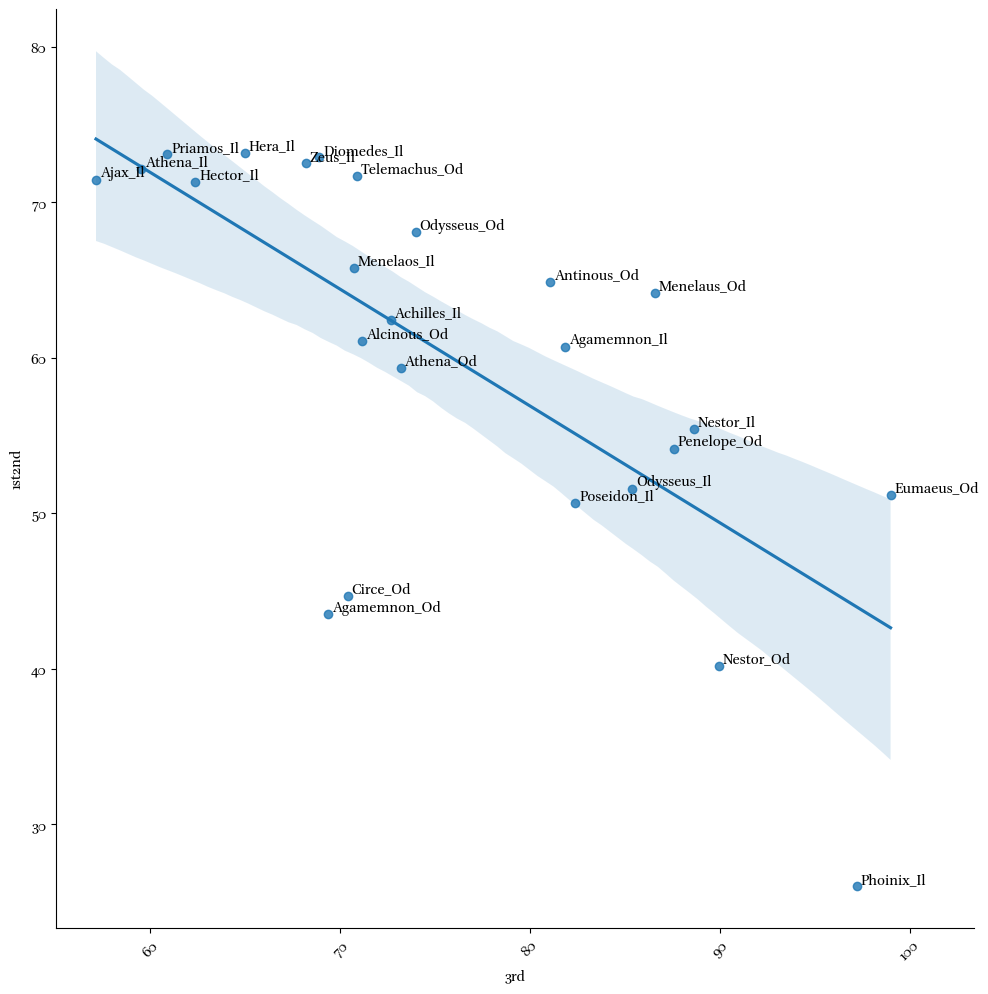

In [48]:
plot_corr(df_feat_top, '3rd', '1st2nd')

#### Verb tenses

We re-do the same work for the verb-mood features. We plot the correlations between the use of indicative and imperative moods in each of the 25 characters

In [49]:
pers_dic = {}

for k,v in il_spk_sents.items():
    # ncount: imperative; vcount: indicative
    ncount, vcount = 0,0
    newk = f'{k}_Il'
    for sent in v:
        for t in sent:
            if not t.get('xpos'):
                continue
            if t.get('xpos', '---------')[4] == 'i':
                vcount += 1
            elif t.get('xpos', '---------')[4] == 'm':
                ncount += 1
    pers_dic[newk] = (vcount, ncount)

for k,v in od_spk_sents.items():
    ncount, vcount = 0,0
    newk = f'{k}_Od'
    for sent in v:
        for t in sent:
            if not t.get('xpos'):
                continue
            if t.get('xpos', '---------')[4] == 'i':
                vcount += 1
            elif t.get('xpos', '---------')[4] == 'm':
                ncount += 1
    pers_dic[newk] = (vcount, ncount)

We can report that Odysseus (*Od*) uses the following verb moods (indicative, imperative). Feel free to change the name if you want to explore other characters!

In [53]:
ind, imp = pers_dic['Odysseus_Od']
print(f'''Odysseus uses the following verb moods:
- indicative: {ind},
- imperative: {imp}''')

Odysseus uses the following verb moods:
- indicative: 1268,
- imperative: 174


Again, we build a dataframe and normalize the counts over the total length of each character's speaking part.

In [51]:
df_feat = pd.DataFrame(data=[v for v in pers_dic.values()], 
                  index=[k for k in pers_dic.keys()], 
                  columns=['indicative', 'imperative'])


tots = df.sum(axis=1)

# we normalize by deviding for the total counts of each character per 1000
df_feat = df_feat.divide(tots, axis='index')
df_feat_top = df_feat.loc[top_char]
df_feat_top = df_feat_top * 1000
df_feat_top.head()

,indicative,imperative
Odysseus_Od,100.237154,13.754941
Achilles_Il,91.049383,14.029181
Telemachus_Od,97.758029,16.966269
Agamemnon_Il,95.441954,14.605893
Nestor_Il,100.527704,14.511873


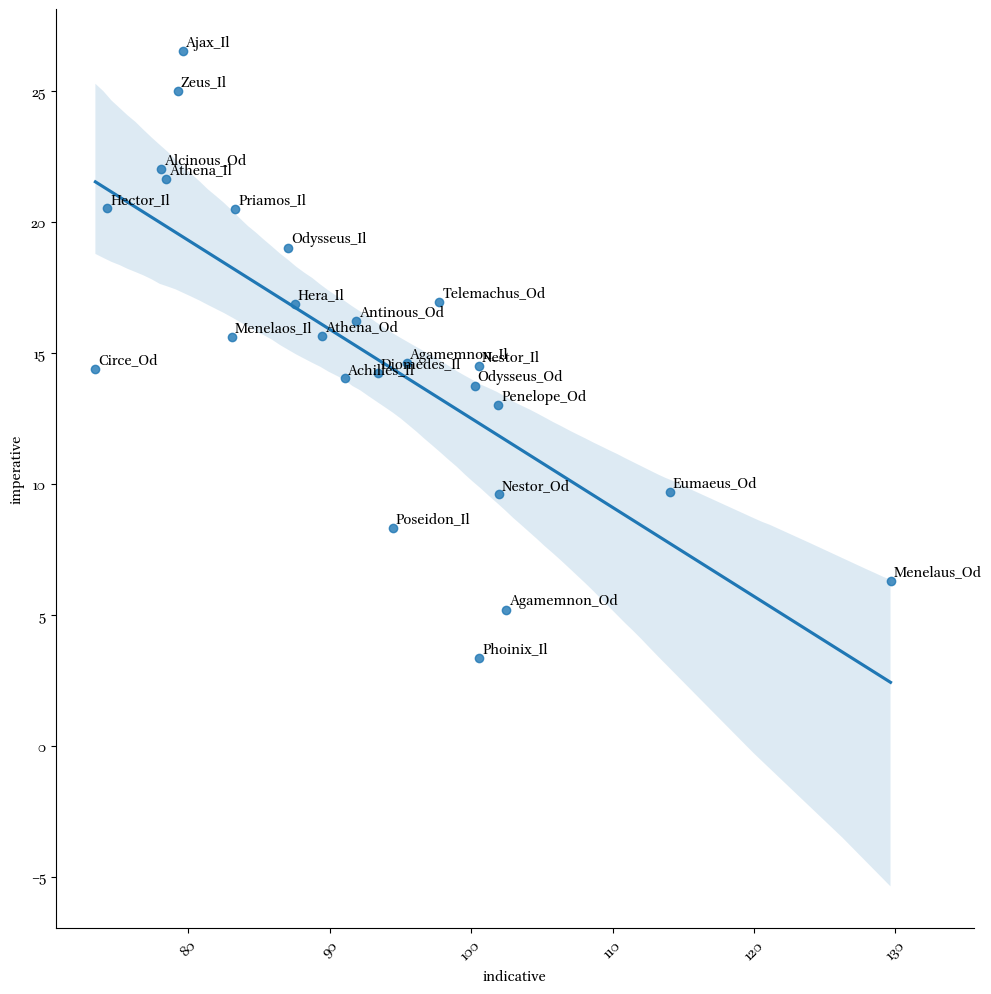

In [52]:
plot_corr(df_feat_top, 'indicative', 'imperative')